In [1]:
## Importing Necesary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pickle
import itertools
import warnings
import os
import sys

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf_ols,adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error
import statsmodels.tsa.api as smt


In [2]:
# Importing the dataset 
data = pd.read_csv(r'A:\Analytix\Machine learning\ML projects\Demand Estimation\Data\Electricity Consumption.csv')
data.head(5)

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [3]:
## Converting Date column to datetime & setting it as index
data['DATE'] = pd.to_datetime(data.DATE,format='%m/%d/%Y')
data = data.set_index(data.DATE)
data['year'] = data.DATE.dt.year
data['month'] = data.DATE.dt.month
data.head(5)

,DATE,Electricty_Consumption_in_TW,year,month
DATE,,,,
1973-01-01,1973-01-01,35.9728,1973,1
1973-02-01,1973-02-01,36.1334,1973,2
1973-03-01,1973-03-01,35.0625,1973,3
1973-04-01,1973-04-01,33.8416,1973,4
1973-05-01,1973-05-01,33.5107,1973,5


In [4]:
def Nan_replace(data):
    if data.isna().any().any():
        data = data.apply(lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean()))

    return data

In [5]:
## Checking data for any null values
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 1973-01-01 to 2019-09-01
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DATE                          561 non-null    datetime64[ns]
 1   Electricty_Consumption_in_TW  561 non-null    float64       
 2   year                          561 non-null    int64         
 3   month                         561 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 21.9 KB


DATE                            0
Electricty_Consumption_in_TW    0
year                            0
month                           0
dtype: int64

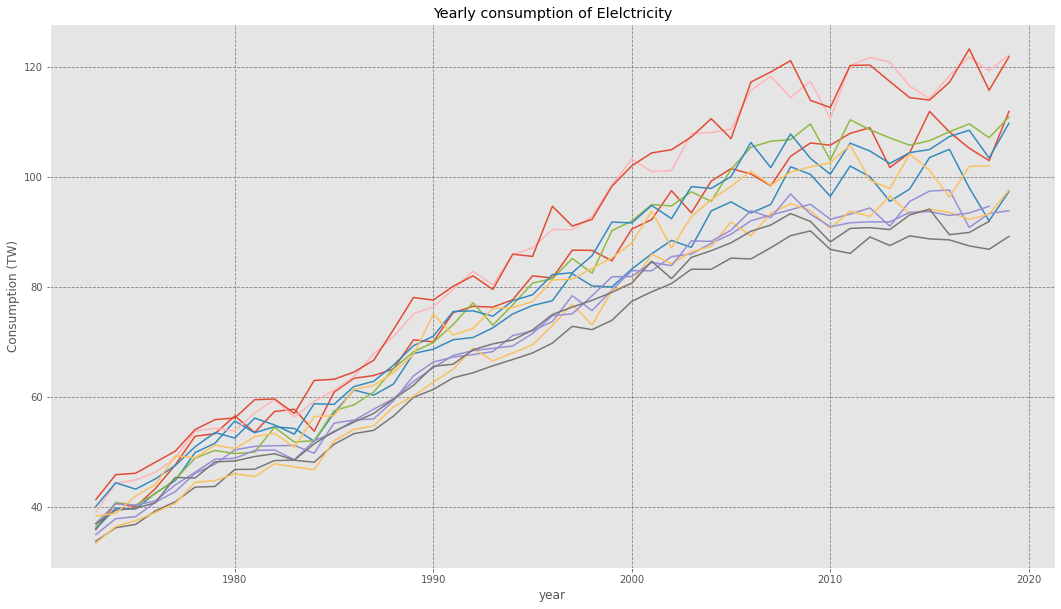

In [183]:
## Creating plot to analyze yearly trend of Electricity consumption

plt.style.use('ggplot')
plt.figure(figsize=(18,10))
plt.plot(data.pivot_table(values='Electricty_Consumption_in_TW',index='year',columns='month'),)
plt.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray')
plt.xlabel("year")
plt.ylabel("Consumption (TW)")
plt.title("Yearly consumption of Elelctricity")
plt.show()

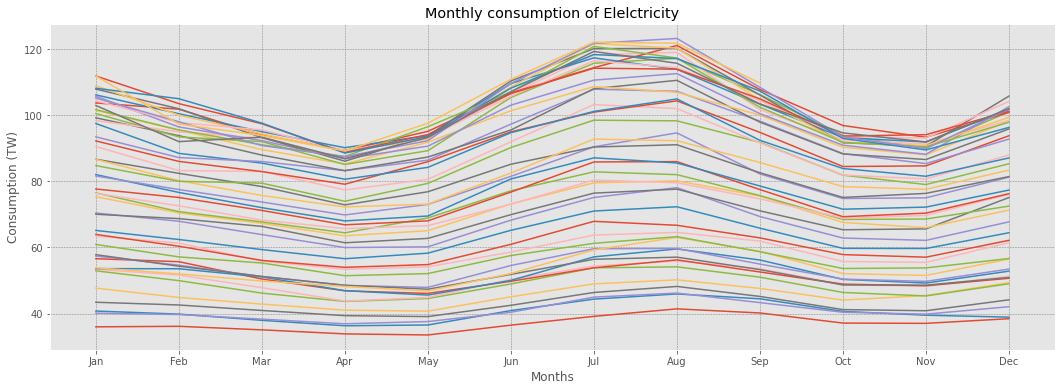

In [184]:
## Creating plot to analyze Monthly trend of Electricity consumption & look for seaonality, if present.

plt.figure(figsize=(18,6))
plt.plot(data.pivot_table(values='Electricty_Consumption_in_TW',index='month',columns='year'))
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.xlabel("Months")
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1, 13), months)
plt.ylabel("Consumption (TW)")
plt.title("Monthly consumption of Elelctricity")
plt.show()

In [6]:
data_f = data['Electricty_Consumption_in_TW']
data_f.head(5)

DATE
1973-01-01    35.9728
1973-02-01    36.1334
1973-03-01    35.0625
1973-04-01    33.8416
1973-05-01    33.5107
Name: Electricty_Consumption_in_TW, dtype: float64

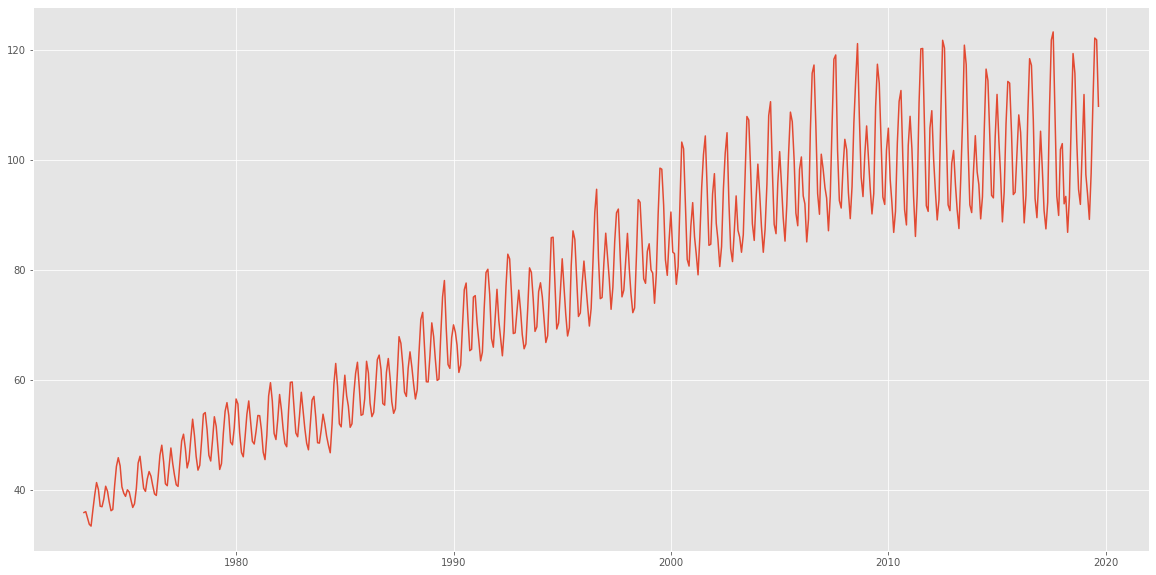

In [186]:
# Creating a plot to define trend wether its upward or downward trend

plt.figure(figsize=(20,10))
plt.plot(data_f)
plt.show()

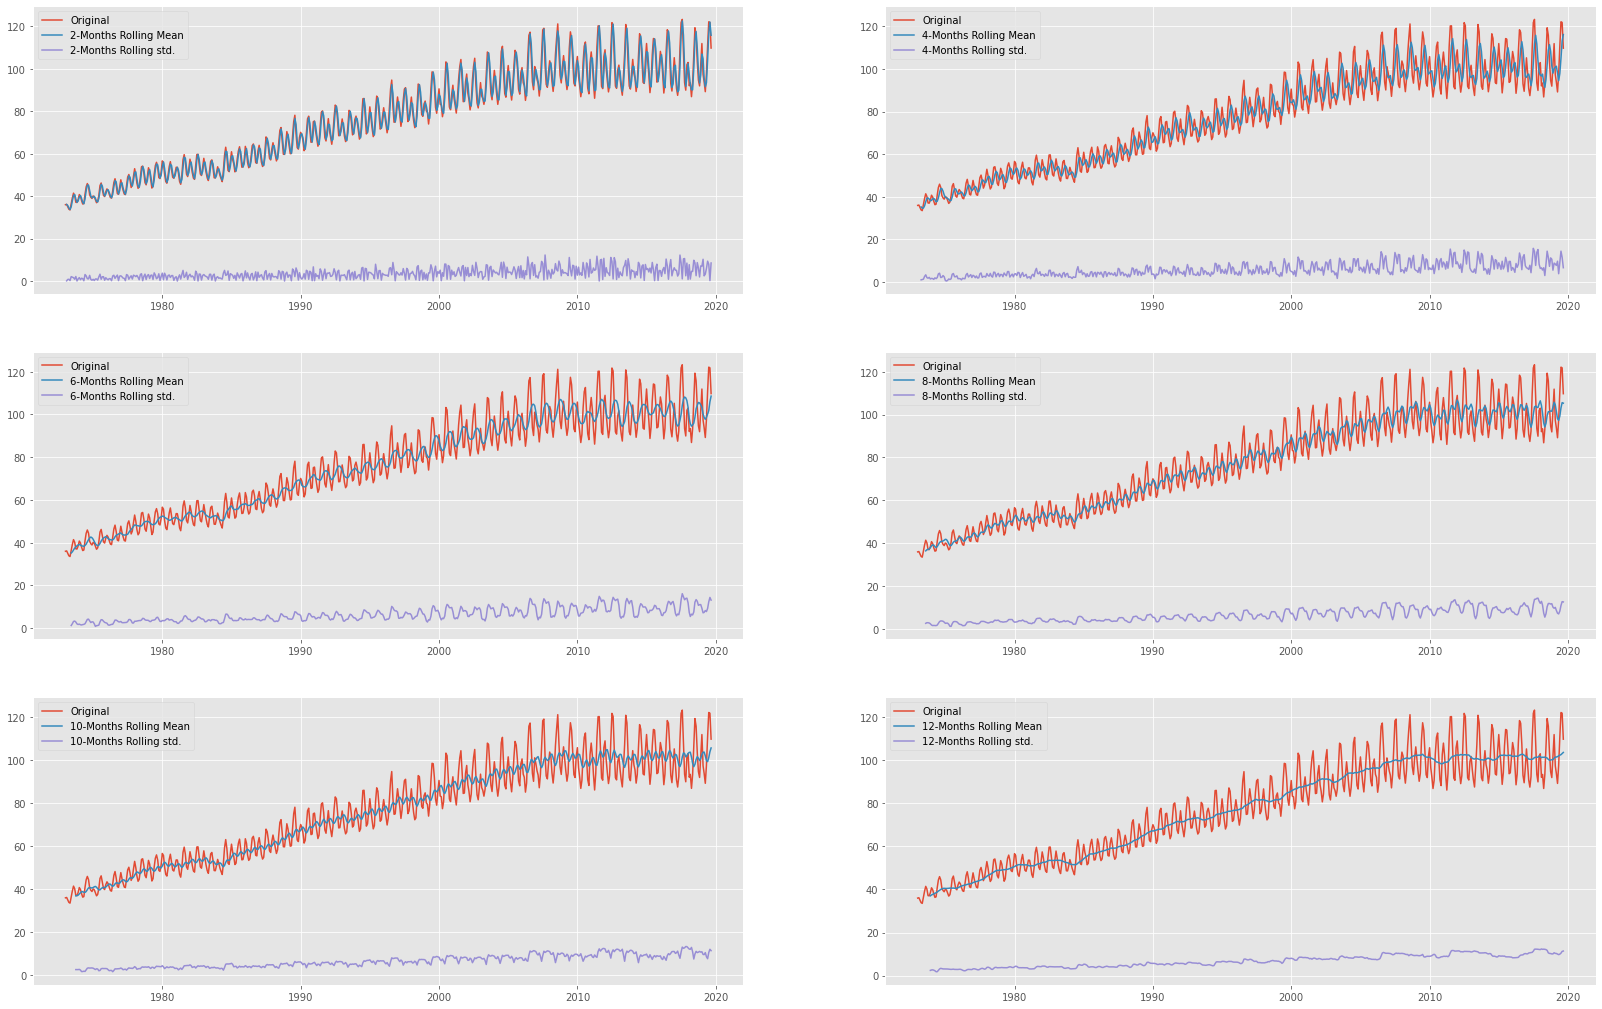

In [187]:
## Creating plot along with rolling mean & standard deviation

fig, axes = plt.subplots(3, 2, sharey=False, sharex=False)
fig.set_figwidth(28)
fig.set_figheight(18)

axes[0, 0].plot(data_f.index, data_f, label='Original')
axes[0, 0].plot(data_f.index, data_f.rolling(window=2).mean(), label='2-Months Rolling Mean')
axes[0, 0].plot(data_f.index, data_f.rolling(window=2).std(), label='2-Months Rolling std.')

axes[0, 1].plot(data_f.index, data_f, label='Original')
axes[0, 1].plot(data_f.index, data_f.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0, 1].plot(data_f.index, data_f.rolling(window=4).std(), label='4-Months Rolling std.')

axes[1, 0].plot(data_f.index, data_f, label='Original')
axes[1, 0].plot(data_f.index, data_f.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[1, 0].plot(data_f.index, data_f.rolling(window=6).std(), label='6-Months Rolling std.')

axes[1, 1].plot(data_f.index, data_f, label='Original')
axes[1, 1].plot(data_f.index, data_f.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1, 1].plot(data_f.index, data_f.rolling(window=8).std(), label='8-Months Rolling std.')

axes[2, 0].plot(data_f.index, data_f, label='Original')
axes[2, 0].plot(data_f.index, data_f.rolling(window=10).mean(), label='10-Months Rolling Mean')
axes[2, 0].plot(data_f.index, data_f.rolling(window=10).std(), label='10-Months Rolling std.')

axes[2, 1].plot(data_f.index, data_f, label='Original')
axes[2, 1].plot(data_f.index, data_f.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[2, 1].plot(data_f.index, data_f.rolling(window=12).std(), label='12-Months Rolling std.')

# Add legends to each subplot
for ax in axes.flatten():
    ax.legend()

plt.show()


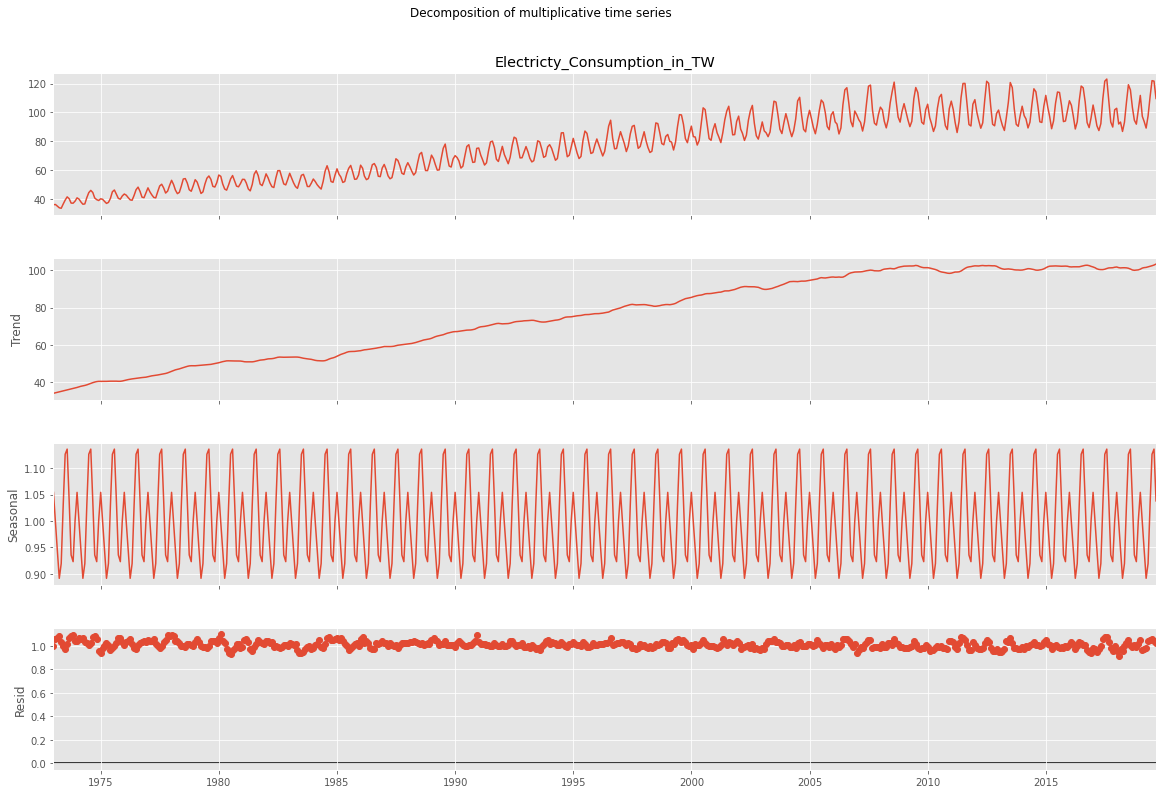

In [188]:
## Decompose plot to get the Trend, Seasonality, & Residuals
decompose = seasonal_decompose(data_f, model='multiplicative', two_sided=False, extrapolate_trend=4)
fig = decompose.plot()
fig.set_figwidth(18)
fig.set_figheight(12)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

In [189]:
## Decompose table to get the Trend, Seasonality & Residuals in numeric format
decompose_tbl= pd.concat([decompose.trend, decompose.seasonal, decompose.resid, decompose.observed],axis=1)
decompose_tbl.columns = ['Trend', 'SI', "Irregular", "Actual"]
decompose_tbl.head(5)

,Trend,SI,Irregular,Actual
DATE,,,,
1973-01-01,34.092018,1.054397,1.000731,35.9728
1973-02-01,34.357224,0.996618,1.055266,36.1334
1973-03-01,34.622430,0.946374,1.070096,35.0625
1973-04-01,34.887636,0.891631,1.087913,33.8416
1973-05-01,35.152842,0.919530,1.036710,33.5107


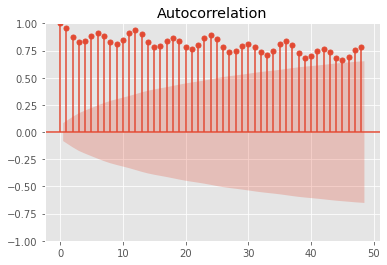

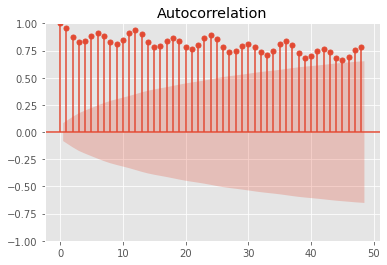

In [190]:
## Creating Auto-Correlation Plot
smt.graphics.plot_acf(data_f, lags=48)

In [7]:
def check_stationarity_and_difference(data, alpha=0.05):

    # Check p-value using the ADF test
    ad_test = adfuller(data)
    p_value = ad_test[1]
    
    # Perform differencing until p-value is below alpha
    while p_value > alpha:
        data = data.diff().dropna()
        ad_test = adfuller(data)
        p_value = ad_test[1]
    
    if p_value <= alpha:
        print("Series is stationary after differencing.")
        return data
    else:
        print("Unable to achieve stationarity after differencing.")
        return data


In [191]:
data_diff = check_stationarity_and_difference(data_f)

Series is stationary after differencing.


<Axes: xlabel='DATE'>

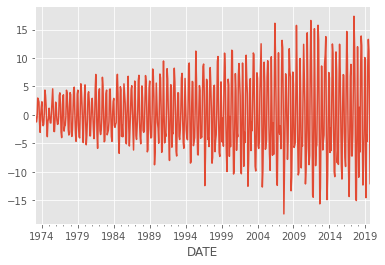

In [192]:
## Plotting Differciated series 
data_diff.plot()

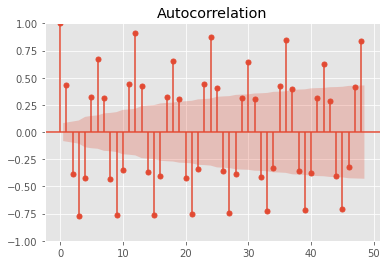

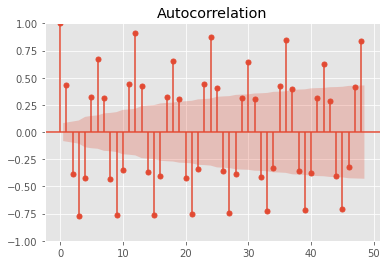

In [193]:
## Creating Auto-Correlation Plot
smt.graphics.plot_acf(data_diff, lags=48)

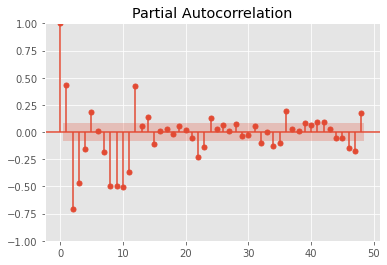

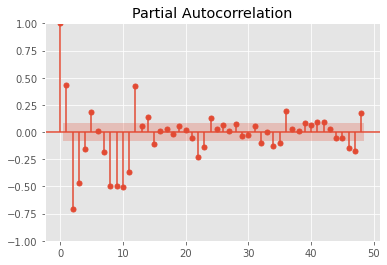

In [194]:
## Creating Pacf plot
smt.graphics.plot_pacf(data_diff, lags = 48, method='ols')

In [8]:
# This function calculates the accuracy of the model
def model_evaluation(Actual,Predicted):

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(Actual,Predicted)

    # Root Mean Squared Error (RMSE)
    rmse = mean_squared_error(Actual, Predicted, squared=False)

    # Coefficient of Determination (R-squared)
    r2 = r2_score(Actual,Predicted)

    #Calculating MAPE
    MAPE = mean_absolute_percentage_error(Actual,Predicted)

    # Print the metrics
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Coefficient of Determination (R-squared):", r2)
    print("Mean Absolute Percentage Error:", MAPE)

In [9]:
size = int(len(data_f)*0.95)

## Train Test split
train = data_f[:size]
test = data_f[size:]

In [197]:
## Below function will find the best values of alpha, beta & gamma

def find_best_params(timeseries,trend=None, seasonal=None, periods=None):


    best_params = None
    best_mae = float('inf')

    alpha_values = [round(x, 1) for x in np.arange(0.1, 1.1, 0.1)]
    beta_values = [round(x, 1) for x in np.arange(0.1, 1.1, 0.1)]
    gamma_values = [round(x, 1) for x in np.arange(0.1, 1.1, 0.1)]

    for a in alpha_values:
        for b in beta_values:
            for g in gamma_values:

                model = ExponentialSmoothing(timeseries, trend=trend, seasonal=seasonal, seasonal_periods=periods)
                model.fit(smoothing_level=a, smoothing_slope=b, smoothing_seasonal=g)
                f_cast = model.predict(model.params, start=timeseries.index[0])
                mae = mean_absolute_error(timeseries, f_cast)

                if mae < best_mae:
                    best_params = {'alpha': a, 'beta': b, 'gamma': g}
                    best_mae = mae

    return best_params


In [ ]:
## Getting the best parameters
find_best_params(train)

In [10]:
alpha = 1.0
beta = 0.1
gamma = 0.1

# initialise model
ES_mdl = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12)
ES_fit = ES_mdl.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\priya\AppData\Local\Temp\ipykernel_17056\1958586879.py:7: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  ES_fit = ES_mdl.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)


In [11]:
## Forcasting values
fcast = ES_fit.forecast(steps=int(len(test)))

In [12]:
## Model evaluation (forward testing)
model_evaluation(test,fcast)

Mean Absolute Error (MAE): 5.022932013857948
Root Mean Squared Error (RMSE): 6.07823586402284
Coefficient of Determination (R-squared): 0.7069642078065759
Mean Absolute Percentage Error: 0.046423272240522714


In [202]:
## below funcrion will find the best values of p,d,q & P,D,Q

def find_best_sarimax_params(timeseries, seasonal_periods, p_range, d_range, q_range, P_range, D_range, Q_range):

    best_params = None
    best_aic = float('inf')

    # Generate all possible combinations of p, d, q, P, D, and Q values
    param_combinations = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))

    for param in param_combinations:
        p, d, q, P, D, Q = param
        order = (p, d, q)
        seasonal_order = (P, D, Q, seasonal_periods)

        # Suppress the convergence warnings to avoid cluttering the output
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            try:
                model = SARIMAX(timeseries, order=order, seasonal_order=seasonal_order)
                result = model.fit(disp=False)
                aic = result.aic

                if aic < best_aic:
                    best_params = {'p': p, 'd': d, 'q': q, 'P': P, 'D': D, 'Q': Q}
                    best_aic = aic

            except:
                # Skip the combination if the model fails to converge
                continue

    return best_params


In [ ]:
## Getting the best parameters
find_best_sarimax_params(train, 12, p_range=(0, 2), d_range=(0, 2), q_range=(0, 2), P_range=(0, 2), D_range=(0, 2), Q_range=(0, 2))

In [13]:
model = SARIMAX(train, order = (2,0,2), seasonal_order= (2,2,2,12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False).fit()

c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\priya\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
# Printing model summary
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:       Electricty_Consumption_in_TW   No. Observations:                  532
Model:             SARIMAX(2, 0, 2)x(2, 2, 2, 12)   Log Likelihood                -968.939
Date:                            Mon, 31 Jul 2023   AIC                           1955.878
Time:                                    14:14:25   BIC                           1993.461
Sample:                                01-01-1973   HQIC                          1970.650
                                     - 04-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3961      0.103     13.589      0.000       1.195       1.597
ar.L2         -0.4002      0.101   

In [15]:
#forward testing
fcst = model.forecast(steps=int(len(test)))

In [16]:
model_evaluation(test,fcst)

Mean Absolute Error (MAE): 2.101792650811314
Root Mean Squared Error (RMSE): 2.642850799880354
Coefficient of Determination (R-squared): 0.9445998597514966
Mean Absolute Percentage Error: 0.02015391523158189


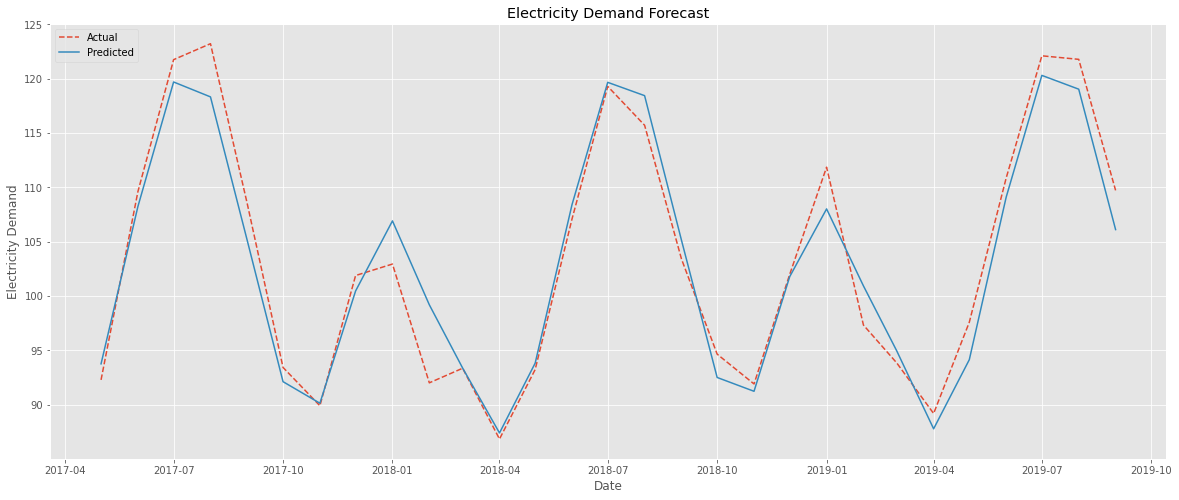

In [208]:
## Creating plot to visualize actual & predicted values by line graph
plt.figure(figsize=(20,8))
plt.plot(test, '--', label='Actual')
plt.plot(fcst, '-', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Electricity Demand')
plt.title('Electricity Demand Forecast')
plt.legend()
plt.show()

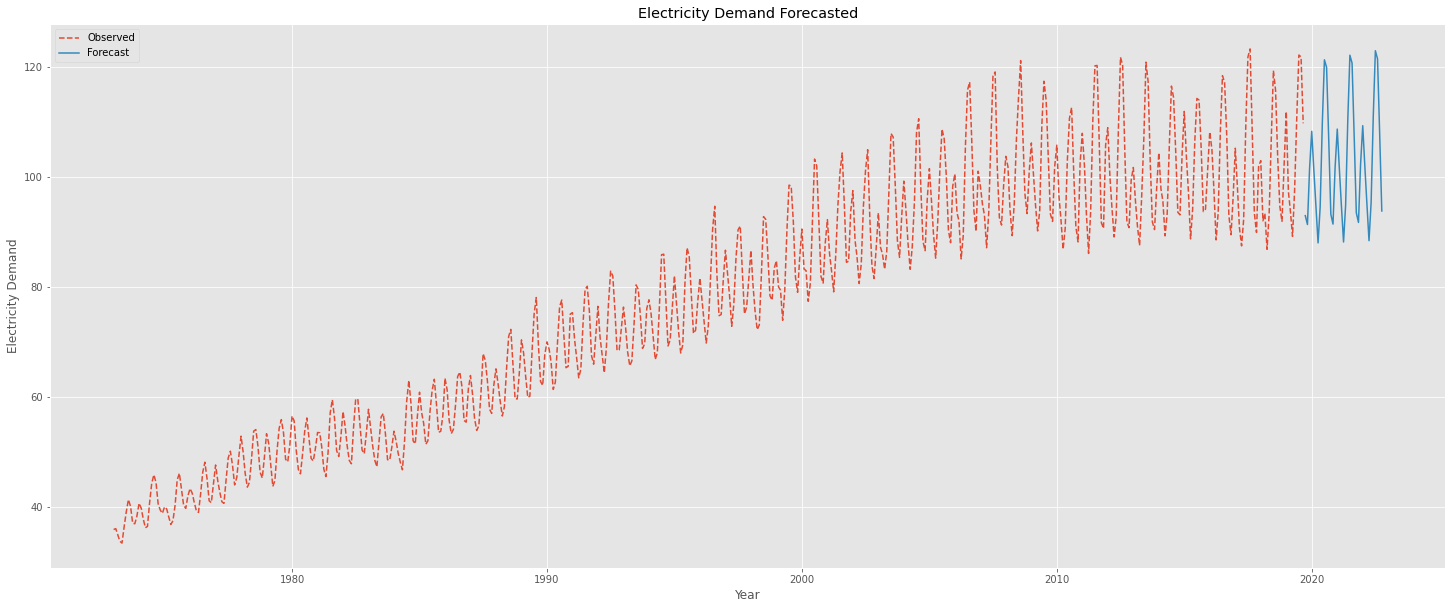

In [209]:
## Plotting the forecasted values
plt.figure(figsize=(25,10))
plt.plot(data_f, '--', label='Observed')
plt.plot(model.predict(start=len(data_f),end=len(data_f)+36), '-', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Electricity Demand')
plt.title('Electricity Demand Forecasted')
plt.legend()
plt.show()

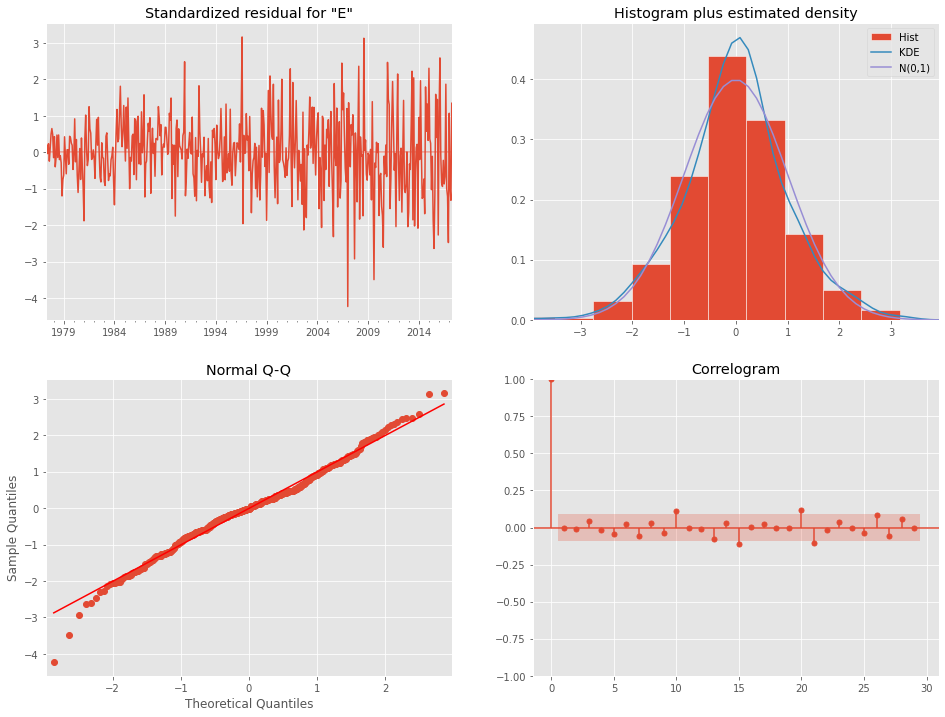

In [210]:
## Getting the diagnostic plot 
model.plot_diagnostics(lags=int(len(fcst)), figsize=(16,12))
plt.show()

In [17]:
path = r'A:\Analytix\Machine learning\ML projects\Demand Estimation\artifacts\model.pkl'

with open(path, 'wb') as f:
    pickle.dump(model, f)